In [18]:
import cv2
from PIL import Image
import numpy as np
import pyvista as pv
import random
import math
import albumentations as A
import matplotlib.pyplot as plt
import imageio
import torch
import torchvision.transforms.functional as tvf

In [75]:
image_path = "./models/data/test_data/raw/sample_000001_data.png"
vtp_path = "./models/data/test_data/vtp/sample_000001_graph.vtp"
seg_path = "./models/data/test_data/seg/sample_000001_seg.png"

In [23]:
class Graph:
    def __init__(self, polydata, h, w):
        self.polydata = polydata
        self.h = h
        self.w = w
        self.points = self._get_points_list()
        self.lines = self._get_lines_list()
        self.conns = self._get_conn_dict()

    def update_points_list(self, new_points_list):
        self.points = new_points_list
        self.conns = self._get_conn_dict()
        return 
        
    def update_lines_list(self, new_lines_list):
        self.lines = new_lines_list
        self.conns = self._get_conn_dict()
        return 
        
    def update_graph(self, new_points_list: None, new_lines_list: None):
        if new_points_list is not None:
            self.update_points_list(new_points_list)
        if new_lines_list is not None:
            self.update_lines_list(new_lines_list)
        return 
        
    def _get_points_list(self):
        points = self.polydata.points.copy()
        points[:, 0] *= self.h
        points[:, 1] *= self.w
        points_list = [(int(point[1]), int(point[0])) for point in points]
        return points_list

    def _get_lines_list(self):
        lines_list = [[self.polydata.lines[i], self.polydata.lines[i+1]]  for i in range(1, len(self.polydata.lines), 3)]
        return lines_list

    def _get_conn_dict(self):
        conns = dict()
        for line in self.lines:
            p1, p2 = line
            if p1 not in conns.keys():
                conns[p1] = []
            if p2 not in conns.keys():
                conns[p2] = []
            if p2 in conns[p1]: 
                continue
            else: 
                conns[p1].append(p2)
            if p1 in conns[p2]: 
                continue
            else: 
                conns[p2].append(p1)
            
        return conns

    def to_polydata(self, new_h = None, new_w = None):
        if new_h is not None:
            self.h = new_h
        
        if new_w is not None:
            self.w = new_w
        points = []
        for coord in self.points: 
            y = coord[1] / self.h
            x = coord[0] / self.w
            point = [y, x, 0]
            points.append(point)
        vtp_points = np.array(points)
        conns = []
        for conn in self.lines:
            conns.append(2)
            for p in conn:
                conns.append(p)
        vtp_lines = np.array(conns)
        if len(vtp_points) > 0:
            self.polydata.points = vtp_points
            self.polydata.lines = vtp_lines
        else:
            self.polydata.points = np.empty((0, 3))
            self.polydata.lines = None
        
        return self.polydata

    def draw_graph(self):
        plotter = pv.Plotter()
        plotter.add_mesh(self.polydata, point_size=10, render_points_as_spheres=True)
        plotter.show()

    def copy(self):
        new_polydata = self.to_polydata()
        return Graph(self.to_polydata(), self.h, self.w)        

In [24]:
class LineData:
    def __init__(self, image, graph):
        self.image = image
        self.graph = graph

    def update_image(self, new_image):
        self.image = new_image

    def update_graph(self, new_points_list: None, new_lines_list: None):
        self.graph.update_graph(new_points_list, new_lines_list)
        return 

In [25]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_array = np.array(image)
polydata = pv.read(vtp_path)
h, w, _ = image.shape

In [26]:
image_path = "./models/data/test_data/raw/sample_000002_data.png"
vtp_path = "./models/data/test_data/vtp/sample_000002_graph.vtp"
seg_path = "./models/data/test_data/seg/sample_000002_seg.png"
image1 = cv2.imread(image_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
polydata1 = pv.read(vtp_path)
h, w, _ = image.shape
graph1 = Graph(polydata1, h, w)
data1 = LineData(image1, graph1)

image_path = "./models/data/test_data/raw/sample_000003_data.png"
vtp_path = "./models/data/test_data/vtp/sample_000003_graph.vtp"
seg_path = "./models/data/test_data/seg/sample_000003_seg.png"
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
polydata2 = pv.read(vtp_path)
h, w, _ = image.shape
graph2 = Graph(polydata2, h, w)
data2 = LineData(image2, graph2)

image_path = "./models/data/test_data/raw/sample_000004_data.png"
vtp_path = "./models/data/test_data/vtp/sample_000004_graph.vtp"
seg_path = "./models/data/test_data/seg/sample_000004_seg.png"
image3 = cv2.imread(image_path)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
polydata3 = pv.read(vtp_path)
h, w, _ = image.shape
graph3 = Graph(polydata3, h, w)
data3 = LineData(image3, graph3)

In [28]:
graph = Graph(polydata, h, w)

In [29]:
data = LineData(image, graph)

In [30]:
datas = [data, data1, data2, data3]

In [31]:
def draw_graph(data: LineData, path: str = "./testing/test.png"):
    image_c = data.image.copy()
    keypoints = data.graph.points
    lines = data.graph.lines
    if len(lines) == 0:
        return cv2.imwrite(path, image_c), image_c
    for line in lines:
        point1 = keypoints[line[0]]
        point1 = (int(point1[0]), int(point1[1]))
        point2 = keypoints[line[1]]
        point2 = (int(point2[0]), int(point2[1]))
        cv2.circle(image_c, point1, radius=2, color=(0, 0, 255), thickness=-1)
        cv2.circle(image_c, point2, radius=2, color=(0, 0, 255), thickness=-1)
        cv2.line(image_c, point1, point2, color=(0, 255, 0))
    return cv2.imwrite(path, image_c), image_c

In [32]:
def draw_compare(image, ori_image, new_image, new_anno_image, title, bw=False):
    cmap = 'viridis' if not bw else 'gray'
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.axis('off') 
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(2, 2, 2)
    plt.axis('off') 
    plt.title("Original Image")
    plt.imshow(ori_image)
    plt.subplot(2, 2, 3)
    plt.axis('off') 
    plt.title(title)
    plt.imshow(new_image, cmap=cmap)
    plt.subplot(2, 2, 4)
    plt.axis('off') 
    plt.title(title)
    plt.imshow(new_anno_image, cmap=cmap)
    plt.show()

In [33]:
def remove_padding(data: LineData, padding_size=(5, 5)):
    if padding_size is None:
        return data
    image = data.image
    graph = data.graph
    h, w, _ = image.shape
    new_image = image[padding_size[0]:(h-padding_size[0]),padding_size[1]:(w-padding_size[1]),:]
    trans_keypoints = [(p[0] - padding_size[1], p[1] - padding_size[0]) for p in graph.points]
    trans_graph = graph.copy()
    trans_graph.update_points_list(trans_keypoints)
    newLineData = LineData(new_image, trans_graph)
    return newLineData

In [34]:
def add_padding(data: LineData, padding_size=(5, 5), bw=False):
    if padding_size is None:
        return data
    image = data.image
    graph = data.graph
    lines = graph.lines
    if not bw:
        h, w, _ = image.shape
    else:
        h, w = image.shape
    new_h = h + padding_size[0] * 2
    new_w = w + padding_size[1] * 2
    if not bw:
        new_image = np.zeros((new_h, new_w, 3), dtype=np.uint8)
        new_image[padding_size[0]:(new_h-padding_size[0]),padding_size[1]:(new_w-padding_size[1]), :] = image
    else:
        new_image = np.zeros((new_h, new_w), dtype=np.uint8)
        new_image[padding_size[0]:(new_h-padding_size[0]), padding_size[1]:(new_w-padding_size[1])] = image
    trans_keypoints = [(p[0] + padding_size[1], p[1] + padding_size[0]) for p in graph.points]
    trans_graph = graph.copy()
    trans_graph.update_graph(trans_keypoints, lines)
    newLineData = LineData(new_image, trans_graph)
    return newLineData

In [35]:
def hori_flip(data: LineData, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, rm_padding)
    image = data.image
    graph = data.graph
    keypoints = np.array([(x, y, 0, 1) for x, y in graph.points])
    transform = A.HorizontalFlip(p=1)
    result = transform(image=image, keypoints=keypoints)
    trans_keypoints = [(point[0], point[1]) for point in result["keypoints"]]
    trans_graph = graph.copy()
    trans_graph.update_points_list(trans_keypoints)
    newLineData = LineData(result["image"], trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [36]:
def vert_flip(data: LineData, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, rm_padding)
    image = data.image
    graph = data.graph
    keypoints =  np.array([(x, y, 0, 1) for x, y in graph.points])
    transform = A.VerticalFlip(p=1)
    result = transform(image=image, keypoints=keypoints)
    trans_keypoints = [(point[0], point[1]) for point in result["keypoints"]]
    trans_graph = graph.copy()
    trans_graph.update_points_list(trans_keypoints)
    newLineData = LineData(result["image"], trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [37]:
def gaussian_blur(data: LineData, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, rm_padding)
    image = data.image
    graph = data.graph
    keypoints = [(x, y, 0, 1) for x, y in graph.points]
    transform = A.GaussianBlur(p=1, blur_limit=(1, 1))
    result = transform(image=image, keypoints=keypoints)
    trans_keypoints = [(point[0], point[1]) for point in result["keypoints"]]
    trans_graph = graph.copy()
    trans_graph.update_points_list(trans_keypoints)
    newLineData = LineData(result["image"], trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [38]:
def jpeg_compress(data: LineData, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, padding)
    image = data.image
    graph = data.graph
    keypoints = [(x, y, 0, 1) for x, y in graph.points]
    transform = A.ImageCompression(p=1, quality_range=(50, 90))
    result = transform(image=image, keypoints=keypoints)
    trans_keypoints = [(point[0], point[1]) for point in result["keypoints"]]
    trans_graph = graph.copy()
    trans_graph.update_points_list(trans_keypoints)
    newLineData = LineData(result["image"], trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [39]:
def black_and_white(data: LineData, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, padding)
    image = data.image
    graph = data.graph
    bw_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    newLineData = LineData(bw_image, graph)
    newLineData = add_padding(newLineData, padding, bw=True)
    return newLineData

In [40]:
def is_valid_coord(invalid_x_start, invalid_x_end, invalid_y_start, invalid_y_end, point, crop_top, crop_left, new_h, new_w):
    xy_valid = [p >= 0 for p in point]
    if crop_left:
        xy_valid[0] = (point[0] >= invalid_x_end) and (point[0] <= new_w)
    else:
        xy_valid[0] = (point[0] <= invalid_x_start) and (point[0] >= 0)
        
    if crop_top: 
        xy_valid[1] = (point[1] >= invalid_y_end) and (point[1] <= new_h)
    else:
        xy_valid[1] = (point[1] <= invalid_y_start) and (point[1] >= 0)
    is_valid = xy_valid[0] and xy_valid[1]
    return is_valid == 1, xy_valid

In [41]:
def get_new_point(point1, point2, new_x = None, new_y = None):
    if new_x is not None:
        if point1[0] > point2[0]:
            right_point = point1
            left_point = point2
        else:
            right_point = point2
            left_point = point1
        ratio = (right_point[0] - new_x) / (right_point[0] - left_point[0] + 1e-9)
        y_offset = (right_point[1] - left_point[1]) * ratio
        if left_point[1] < 0:
            y_offset *= -1
        if right_point[1] == left_point[1]:
            new_x_pos = right_point[1]
        new_y_pos = right_point[1] - y_offset
        new_point = (int(new_x), int(new_y_pos))
    elif new_y is not None:
        if point1[1] > point2[1]:
            top_point = point1
            bot_point = point2
        else:
            top_point = point2
            bot_point = point1
        
        ratio = (top_point[1] - new_y) / (top_point[1] - bot_point[1] + 1e-9)
        x_offset = (top_point[0] - bot_point[0]) * ratio

        if bot_point[1] < 0:
            x_offset *= -1
        new_x_pos = top_point[0] - x_offset
        if top_point[0] == bot_point[0]:
            new_x_pos = top_point[0]
        new_point = (int(new_x_pos), int(new_y))
    return new_point

In [42]:
def get_points_dist(point1, point2):
    return int(np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2))

In [43]:
def prune_graph(graph: Graph, angle_thresh=160):
    coord = np.array(graph.points)
    edge = np.array(graph.lines)

    dist_adj = np.zeros((coord.shape[0], coord.shape[0]))
    dist_adj[edge[:, 0], edge[:, 1]] = np.sum((coord[edge[:, 0], :] - coord[edge[:, 1], :]) ** 2, 1)
    dist_adj[edge[:, 1], edge[:, 0]] = np.sum((coord[edge[:, 0], :] - coord[edge[:, 1], :]) ** 2, 1)
    start = True
    node_mask = np.ones(coord.shape[0], dtype=np.bool)
    while start:
        degree = (dist_adj > 0).sum(1)
        deg_2 = list(np.where(degree == 2)[0])
        if len(deg_2) == 0:
            start = False
        np.random.shuffle(deg_2)
        for n, idx in enumerate(deg_2):
            deg_2_neighbor = np.where(dist_adj[idx, :] > 0)[0]

            p1 = coord[idx, :]
            p2 = coord[deg_2_neighbor[0], :]
            p3 = coord[deg_2_neighbor[1], :]
            l1 = p2 - p1
            l2 = p3 - p1
            node_angle = angle(l1, l2) * 180 / math.pi
            if node_angle > angle_thresh:
                node_mask[idx] = False
                dist_adj[deg_2_neighbor[0], deg_2_neighbor[1]] = np.sum((p2 - p3) ** 2)
                dist_adj[deg_2_neighbor[1], deg_2_neighbor[0]] = np.sum((p2 - p3) ** 2)

                dist_adj[idx, deg_2_neighbor[0]] = 0.0
                dist_adj[deg_2_neighbor[0], idx] = 0.0
                dist_adj[idx, deg_2_neighbor[1]] = 0.0
                dist_adj[deg_2_neighbor[1], idx] = 0.0
                break
            elif n == len(deg_2) - 1:
                start = False

    new_coord = coord[node_mask, :]
    new_dist_adj = dist_adj[np.ix_(node_mask, node_mask)]
    new_edge = np.array(np.where(np.triu(new_dist_adj) > 0)).T

    new_points = []
    new_lines = []
    for coord in new_coord:
        new_points.append((int(coord[0]), int(coord[1])))
    for edge in new_edge:
        new_lines.append([int(edge[0]), int(edge[1])])
    new_graph = graph.copy()
    new_graph.update_graph(new_points, new_lines)
    return new_graph


In [44]:
def randomize_points_order(graph: Graph):
    points = graph.points
    lines = graph.lines
    n = len(points)
    old_indices = list(range(n))
    new_indices = old_indices.copy()
    random.shuffle(new_indices) 

    index_map = {old: new for new, old in enumerate(new_indices)}

    new_points = [points[i] for i in new_indices]

    new_lines = []
    for line in lines:
        i1, i2 = line
        new_i1 = index_map[i1]
        new_i2 = index_map[i2]
        new_lines.append([new_i1, new_i2])
    new_graph = graph.copy()
    new_graph.update_graph(new_points, new_lines)
    return new_graph

In [45]:
def angle(v1, v2):
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    return np.arccos(np.clip(dot_product, a_min=-1, a_max=1))

In [46]:
def random_crop(data: LineData, max_crop_size=None, fix_crop_size=False, rm_padding=None, padding=None, p=0.5, info=False):
    if random.random() > p:
        return data
    data = remove_padding(data, rm_padding)
    image = data.image
    h, w, _ = image.shape
    graph = data.graph
    points = graph.points
    lines = graph.lines
    conns = graph.conns
    
    crop_top = random.random() > 0.5
    crop_left = random.random() > 0.5
    if max_crop_size is None:
        max_height_crop_size = h * 0.8
        max_width_crop_size = w * 0.8
    elif type(max_crop_size) is list:
        assert max_crop_size[0] < h and max_crop_size[1] < w, "Invalid crop_size."
        max_height_crop_size, max_width_crop_size = max_crop_size
    elif type(max_crop_size) is int:
        assert max_crop_size < h and max_crop_size < w, "Invalid crop_size."
        max_height_crop_size = max_crop_size
        max_width_crop_size = max_crop_size
    else:
        raise ValueError('Invalid crop_size.')
    
    height_crop_size = random.randint(0, max_height_crop_size) if not fix_crop_size else max_height_crop_size
    width_crop_size = random.randint(0, max_width_crop_size) if not fix_crop_size else max_width_crop_size
    if crop_top:
        new_y_start, new_y_end = height_crop_size, h
        invalid_y_start, invalid_y_end = 0, height_crop_size
        points = [(point[0], point[1] - height_crop_size) for point in points]
    else:
        new_y_start, new_y_end = 0, h - height_crop_size
        invalid_y_start, invalid_y_end = h - height_crop_size, h
    if crop_left:
        new_x_start, new_x_end = width_crop_size, w
        invalid_x_start, invalid_x_end = 0, width_crop_size
        points = [(point[0] - width_crop_size, point[1]) for point in points]
    else:
        new_x_start, new_x_end = 0, w - width_crop_size
        invalid_x_start, invalid_x_end = w - width_crop_size, w
    new_image = image[new_y_start:new_y_end, new_x_start:new_x_end, :]
    # print(new_image.shape, height_crop_size, width_crop_size)
    new_h, new_w = new_image.shape[:2]
    new_point_id = 0
    new_points = []
    new_lines = []
    for i, point in enumerate(points):
             
        is_valid, xy_valid = is_valid_coord(
            invalid_x_start, invalid_x_end, invalid_y_start, \
            invalid_y_end, point, crop_top, crop_left, new_h, new_w
        )
        if is_valid:
            if point in new_points:
                conn_ids = conns[i]
                curr_point_id = new_points.index(point)
            else:                
                conn_ids = conns[i]
                new_points.append(point)
                curr_point_id = new_point_id
                new_point_id += 1
            for conn_id in conn_ids:
                conn_point = points[conn_id]
                conn_is_valid, conn_xy_valid = is_valid_coord(
                    invalid_x_start, invalid_x_end, invalid_y_start, \
                    invalid_y_end, conn_point, crop_top, crop_left, new_h, new_w
                )
                if conn_is_valid:
                    if conn_point in new_points: 
                        continue
                    else:
                        new_points.append(conn_point)
                        conn_point_id = new_point_id
                        new_lines.append([curr_point_id, conn_point_id])
                        
                else: # curr valid but conn invalid -> create new node
                    new_x = new_x_start if crop_left else new_x_end
                    new_y = new_y_start if crop_top else new_y_end
                    new_point = get_new_point(point, conn_point, new_x = new_x)
                    new_point_is_valid, _ = is_valid_coord(
                        invalid_x_start, invalid_x_end, invalid_y_start, \
                        invalid_y_end, new_point, crop_top, crop_left, new_h, new_w
                    )
                    if not new_point_is_valid:
                        new_point = get_new_point(point, conn_point, new_y = new_y)
                        new_point_is_valid, _ = is_valid_coord(
                            invalid_x_start, invalid_x_end, invalid_y_start, \
                            invalid_y_end, new_point, crop_top, crop_left, new_h, new_w
                        )
                        if not new_point_is_valid:
                            raise ValueError("New point error")
                    x_dist = (point[0] - new_point[0]) ** 2
                    y_dist = (point[1] - new_point[1]) ** 2
                    if new_point in new_points or (x_dist < 20 and y_dist < 20): 
                        continue
                    
                    new_points.append(new_point)
                    new_point_id = new_point_id
                    new_lines.append([curr_point_id, new_point_id])

                new_point_id += 1
    trans_graph = graph.copy()
    trans_graph.h = new_image.shape[0]
    trans_graph.w = new_image.shape[1]
    trans_graph.update_graph(new_points, new_lines)
    newLineData = LineData(new_image, trans_graph)
    newLineData = add_padding(newLineData, padding)
    if not info:
        return newLineData
        
    crop_info = {
        "crop_top": crop_top, 
        "crop_left": crop_left,
        "height_crop": height_crop_size,
        "width_crop": width_crop_size,
    }
    return newLineData, crop_info

In [47]:
def random_hide(data: LineData, max_hide_size=None, fix_hide_size=False, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, padding)
    image = data.image
    h, w, _ = image.shape
    graph = data.graph
    points = graph.points
    lines = graph.lines
    conns = graph.conns
    
    crop_line_data, crop_info = random_crop(data, max_hide_size, fix_hide_size, rm_padding=None, padding=None, p=1, info=True)
    crop_image = crop_line_data.image
    crop_image_h, crop_image_w, crop_image_c = crop_image.shape
    height_crop = crop_info["height_crop"]
    width_crop = crop_info["width_crop"]
    new_image = np.zeros((crop_image_h + height_crop, crop_image_w + width_crop, crop_image_c))
    x_start = width_crop if crop_info["crop_left"] else 0
    y_start = height_crop if crop_info["crop_top"] else 0

    new_image[y_start:(y_start+crop_image_h), x_start:(x_start+crop_image_w), :] = crop_image
    trans_graph = crop_line_data.graph.copy()
    new_points = [(p[0] + x_start, p[1] + y_start) for p in trans_graph.points]
    
    trans_graph.update_points_list(new_points)
    newLineData = LineData(new_image, trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [48]:
def random_add_point(data: LineData, max_add_point_num=5, min_points_dist=10, rm_padding=None, padding=None, p=0.5):
    if random.random() > p:
        return data
    data = remove_padding(data, rm_padding)
    image = data.image
    h, w, _ = image.shape
    graph = data.graph
    points = graph.points
    lines = graph.lines
    conns = graph.conns
    added_point_num = 0
    new_point_id = 0
    new_points = points.copy()
    new_lines = lines.copy()
    rm_conn = []
    while added_point_num < max_add_point_num:
        for i, point in enumerate(points):
            new_point = None
            conn_ids = conns[i]
            for conn_id in conn_ids:
                if [i, conn_id] in rm_conn or [conn_id, i] in rm_conn:
                    continue
                conn_point = points[conn_id]
                curr_x, curr_y = point
                conn_x, conn_y = conn_point
                x_dist = curr_x - conn_x if curr_x > conn_x else conn_x - curr_x
                y_dist = curr_y - conn_y if curr_y > conn_y else conn_y - curr_y
                r = random.random()
                if x_dist > min_points_dist and random.random() > 0.5:
                    new_x = int(curr_x * (1-r) + conn_x * r)
                    new_point = get_new_point(point, conn_point, new_x=new_x)
                elif y_dist > min_points_dist:
                    new_y = int(curr_y * (1-r) + conn_y * r)
                    new_point = get_new_point(point, conn_point, new_y=new_y)
                elif x_dist > min_points_dist :
                    new_x = int(curr_x * (1-r) + conn_x * r)
                    new_point = get_new_point(point, conn_point, new_x=new_x)
                else:
                    continue
                if new_point:
                    added_point_num += 1
                    try:
                        new_lines.remove([i, conn_id])
                        rm_conn.append([conn_id, i])
                    except:
                        new_lines.remove([conn_id, i])
                        rm_conn.append([i, conn_id])
                    new_points.append(new_point)
                    new_point_id = len(new_points)-1
                    new_lines.append([i, new_point_id])
                    new_lines.append([conn_id, new_point_id])
    
    trans_graph = graph.copy()
    trans_graph.update_graph(new_points, new_lines)
    trans_graph = randomize_points_order(trans_graph)
    trans_graph = prune_graph(trans_graph, 160)
    newLineData = LineData(image, trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

In [49]:
def center_padding(data: LineData, target_size):
    
    if type(target_size) == int:
        target_h, target_w = target_size, target_size
    else:
        target_h, target_w = target_size

    image = data.image
    h, w, _ = image.shape
    graph = data.graph
    points = graph.points
    lines = graph.lines

    left_pad = (target_w - w) // 2
    right_pad = target_w - w - left_pad
    top_pad = (target_h - h) // 2
    bot_pad = target_h - h - top_pad

    new_image = np.zeros((target_h, target_w, 3), np.uint8)
    
    new_image[top_pad:(target_h-bot_pad), left_pad:(target_w-right_pad), :] = image
    new_points = [(x+left_pad, y+top_pad) for x, y in points]
    trans_graph = graph.copy()
    trans_graph.update_graph(new_points, lines)
    newLineData = LineData(new_image, trans_graph)
    return newLineData

In [50]:
def mosaic(datas: list[LineData], rm_padding=None, padding=None, prop=0.4):
    h_padd, w_padd = 0, 0
    if rm_padding is not None:
        h_padd = rm_padding[0] * 2
        w_padd = rm_padding[1] * 2
    image = datas[0].image
    h, w, _ = image.shape
    final_padding = [0, 0]
    if padding is not None:
        final_padding = [x for x in padding]
        h -= final_padding[0] * 2
        w -= final_padding[1] * 2
    print(h, w)
    x_split = int(np.random.uniform(prop, 1-prop) * w)
    y_split = int(np.random.uniform(prop, 1-prop) * h)
    image_range_list = [
        [(0, x_split), (0, y_split)], # left top 0
        [(x_split, w), (0, y_split)], # right top 1
        [(0, x_split), (y_split, h)], # left bot 2
        [(x_split, w), (y_split, h)], # right bot 3
    ] 
    print(x_split, y_split)
    print(image_range_list)
    print("sdfasdf")
    padding_image_start = [
        [[final_padding[1], 0], [final_padding[0], 0]], # left top 0
        [[0, final_padding[1]], [final_padding[0], 0]], # right top 1
        [[final_padding[1], 0], [0, final_padding[0]]], # left bot 2
        [[0, final_padding[1]], [0, final_padding[0]]], # right bot 3
    ]
    new_image = np.zeros((h-2*final_padding[1], w-2*final_padding[0], 3), dtype=np.uint8)
    order = [0, 1, 2, 3]
    random.shuffle(order)
    new_points = []
    new_lines = []
    for i, data_idx in enumerate(order):
        data = datas[data_idx]
        crop_size = [abs(h - image_range_list[i][1][1] - image_range_list[i][1][0])-h_padd+final_padding[0], abs(w - image_range_list[i][0][1] - image_range_list[i][0][0])-w_padd+final_padding[1]]
        print(crop_size)
        crop_data = random_crop(data, max_crop_size=crop_size, fix_crop_size=True, rm_padding=rm_padding, padding=rm_padding, p=1)
        print(new_image[
            (image_range_list[i][1][0]):(image_range_list[i][1][1]),
            (image_range_list[i][0][0]):(image_range_list[i][0][1]), 
            :
        ].shape, "new")
        print(crop_data.image.shape)
        new_image[
            (image_range_list[i][1][0]):(image_range_list[i][1][1]),
            (image_range_list[i][0][0]):(image_range_list[i][0][1]), 
            :
        ] = crop_data.image.astype(int)
        point_index_start = len(new_points)
        trans_points = [(x + image_range_list[i][0][0], y + image_range_list[i][1][0]) for x, y in crop_data.graph.points]
        new_points.extend(trans_points)
        new_lines.extend([[p1+point_index_start, p2+point_index_start] for p1, p2 in crop_data.graph.lines])
    trans_graph = graph.copy()
    trans_graph.update_graph(new_points, new_lines)
    newLineData = LineData(new_image, trans_graph)
    newLineData = add_padding(newLineData, padding)
    return newLineData

128 128
72 58
[[(0, 72), (0, 58)], [(72, 128), (0, 58)], [(0, 72), (58, 128)], [(72, 128), (58, 128)]]
sdfasdf
[70, 56]
(58, 72, 3) new
(58, 72, 3)
[70, 72]
(58, 56, 3) new
(58, 56, 3)
[58, 56]
(70, 72, 3) new
(70, 72, 3)
[58, 72]
(70, 56, 3) new
(70, 56, 3)
(128, 128, 3)


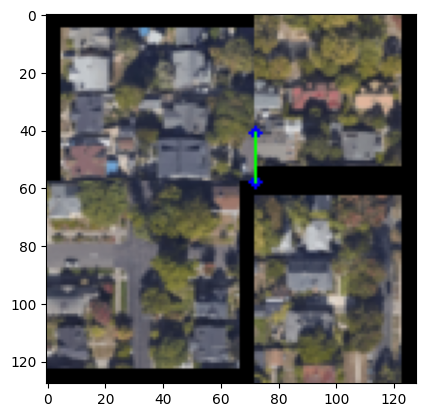

In [64]:
mosaic_LineData = mosaic(datas)
_, mosaic_image = draw_graph(mosaic_LineData)
print(mosaic_LineData.image.shape)
plt.imshow(mosaic_image)

[64, 72]
(64, 56, 3) new
(64, 56, 3)
[64, 56]
(64, 72, 3) new
(64, 72, 3)
[64, 72]
(64, 56, 3) new
(64, 56, 3)
[64, 56]
(64, 72, 3) new
(64, 72, 3)


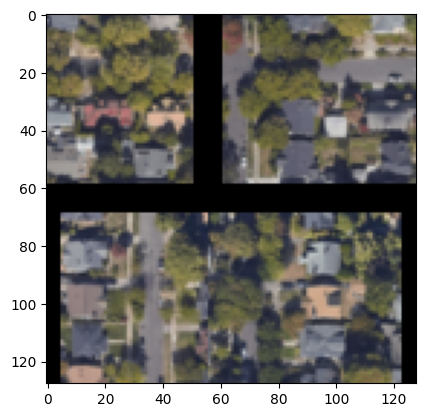

In [99]:
mosaic_LineData = mosaic(datas)
_, mosaic_image = draw_graph(mosaic_LineData)
plt.imshow(mosaic_LineData.image)

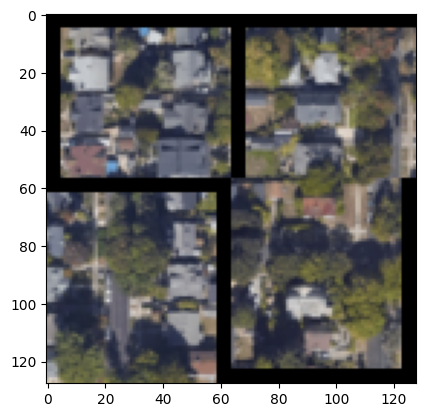

In [128]:
plt.imshow(mosaic_LineData.image)

In [439]:
addpad_LineData = center_padding(crop_LineData1, target_size=(128, 128))
_ , addpad_image = draw_graph(addpad_LineData)

In [632]:
crop_LineData1 = random_crop(data, max_crop_size=[25, 15], fix_crop_size=False, p=1)
_, crop_image1 = draw_graph(crop_LineData1)

In [614]:
addpoint_LineData = random_add_point(data, max_add_point_num=5, min_points_dist=3, rm_padding=[5,5], padding=[5,5])
_, addpoint_image = draw_graph(addpoint_LineData)

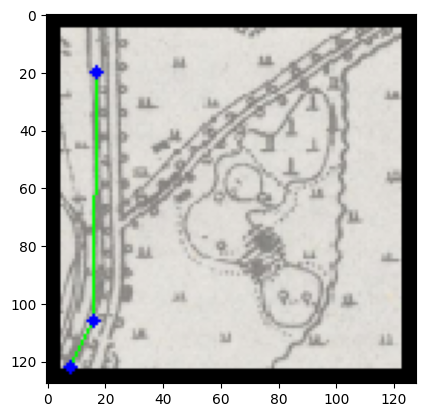

In [615]:
plt.imshow(addpoint_image)

In [617]:
hori_LineData = hori_flip(data, p=1)
vert_LineData = vert_flip(data, p=1)
_, ori_image = draw_graph(data)
_, hori_image = draw_graph(hori_LineData)
_, vert_image = draw_graph(vert_LineData)
gblur_LineData = gaussian_blur(data, p=1)
_, gblur_image = draw_graph(gblur_LineData)
jpeg_LineData = jpeg_compress(data, p=1)
_, jpeg_image = draw_graph(jpeg_LineData)
bw_LineData = black_and_white(data, p=1)
_, bw_image = draw_graph(bw_LineData)
crop_LineData1 = random_crop(data, max_crop_size=[25, 15], fix_crop_size=False, p=1)
_, crop_image1 = draw_graph(crop_LineData1)
crop_LineData2 = random_crop(data, max_crop_size=[15, 30], fix_crop_size=False, p=1)
_, crop_image2 = draw_graph(crop_LineData2)
hide_LineData = random_hide(data, max_hide_size=[25, 15], fix_hide_size=False, rm_padding=[5,5], padding=[5,5], p=1)
_, hide_image = draw_graph(hide_LineData)

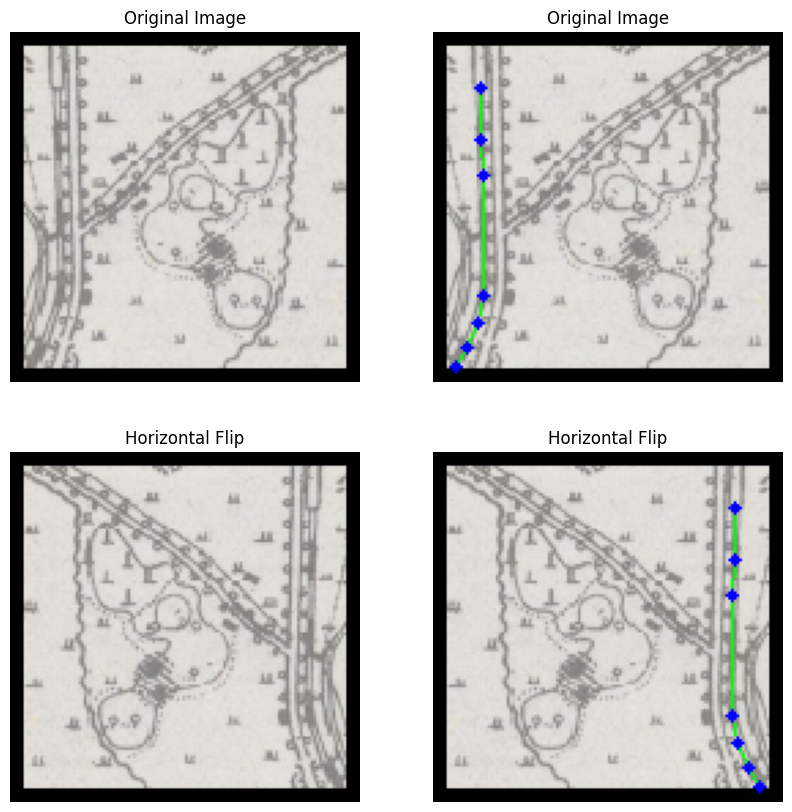

In [458]:
draw_compare(image, ori_image, hori_LineData.image, hori_image, "Horizontal Flip")

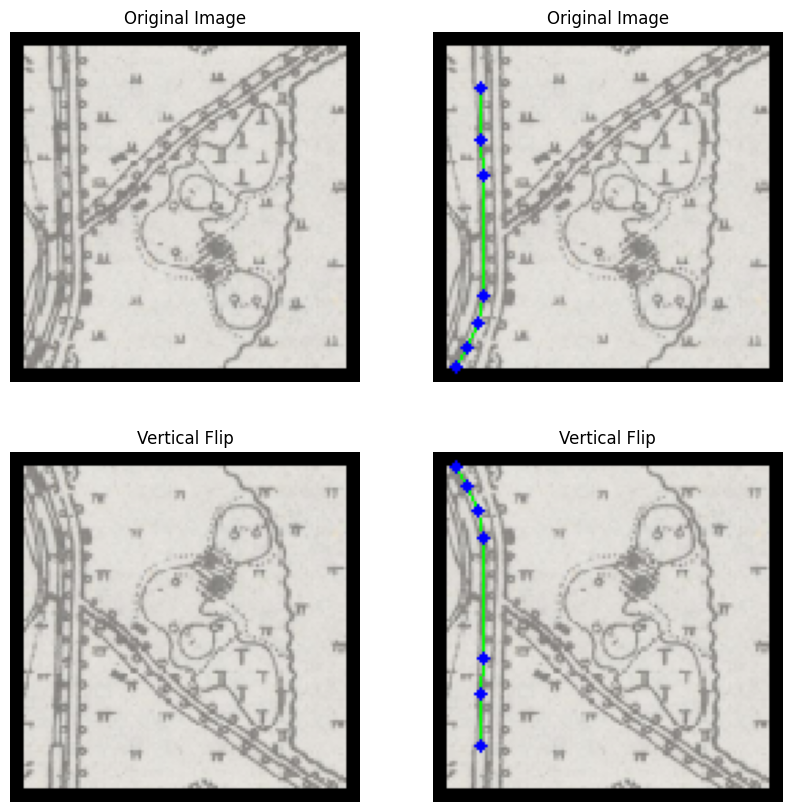

In [459]:
draw_compare(image, ori_image, vert_LineData.image, vert_image, "Vertical Flip")

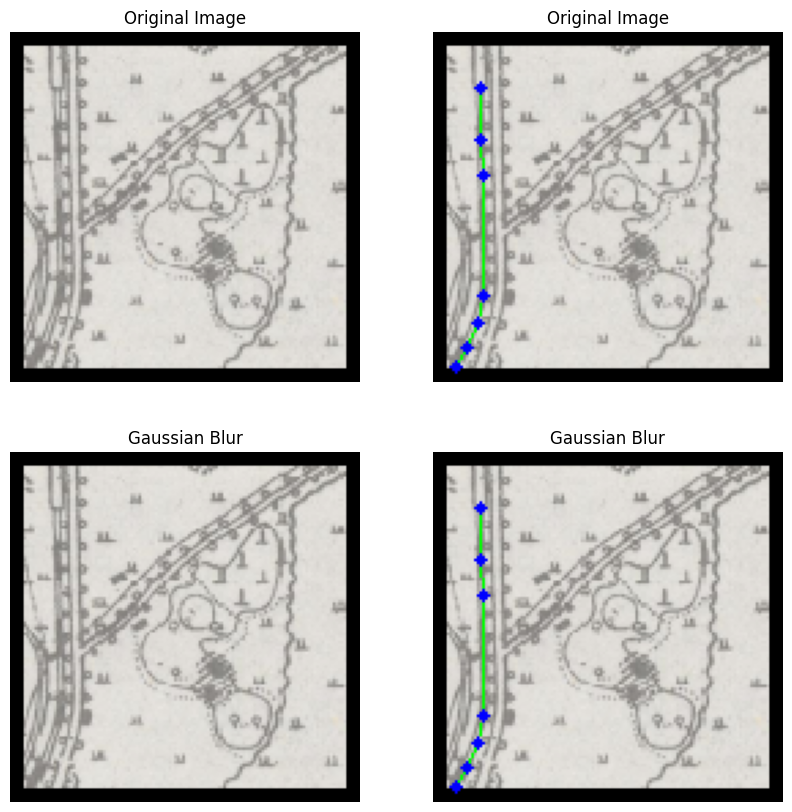

In [460]:
draw_compare(image, ori_image, gblur_LineData.image, gblur_image, "Gaussian Blur")

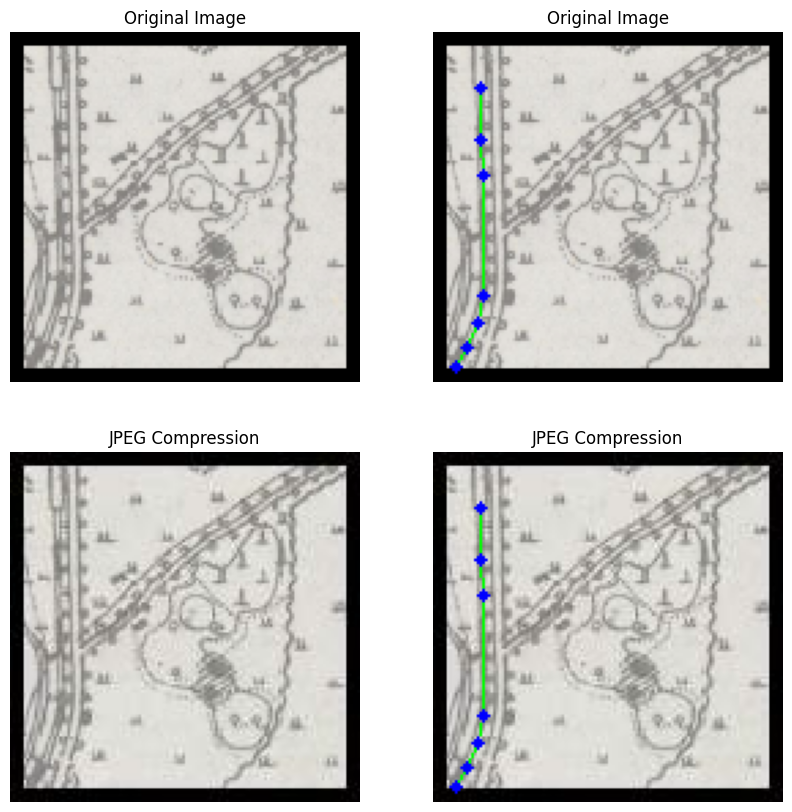

In [461]:
draw_compare(image, ori_image, jpeg_LineData.image, jpeg_image, "JPEG Compression")

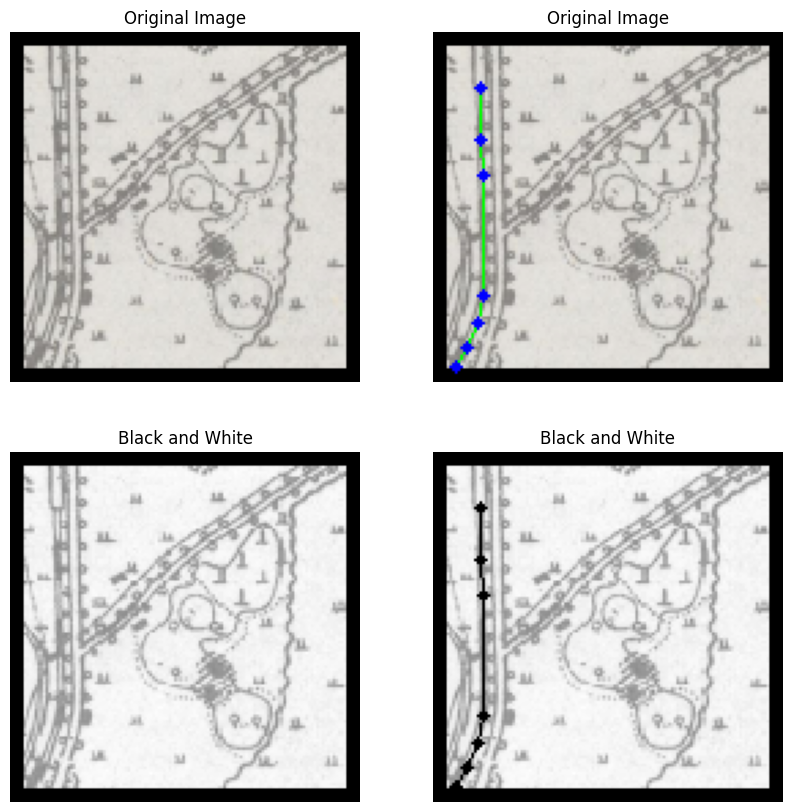

In [462]:
draw_compare(image, ori_image, bw_LineData.image, bw_image, "Black and White", bw=True)

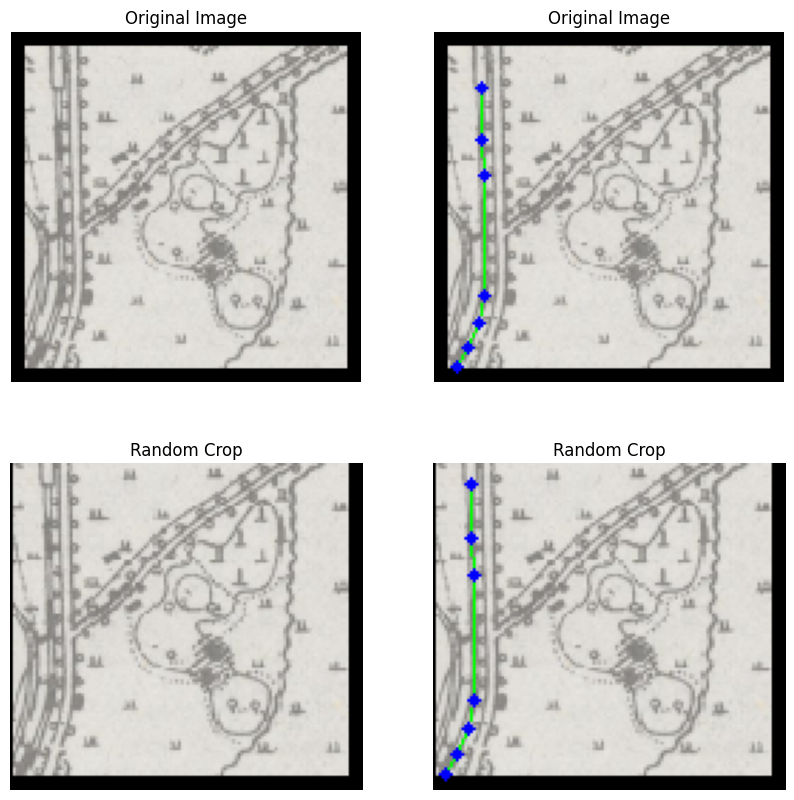

In [463]:
draw_compare(image, ori_image, crop_LineData1.image, crop_image1, "Random Crop", bw=False)

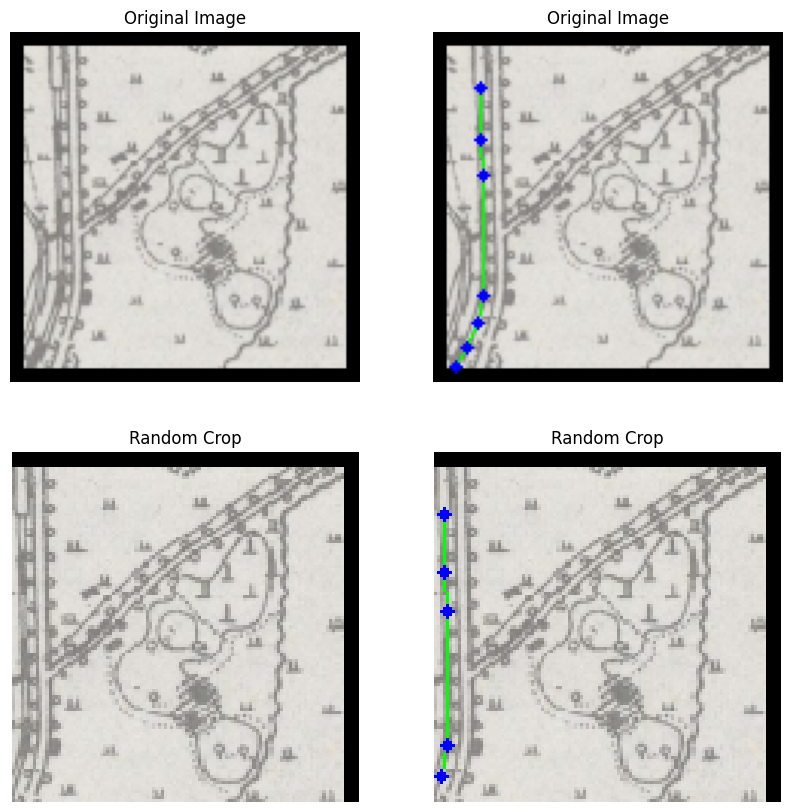

In [464]:
draw_compare(image, ori_image, crop_LineData2.image, crop_image2, "Random Crop", bw=False)

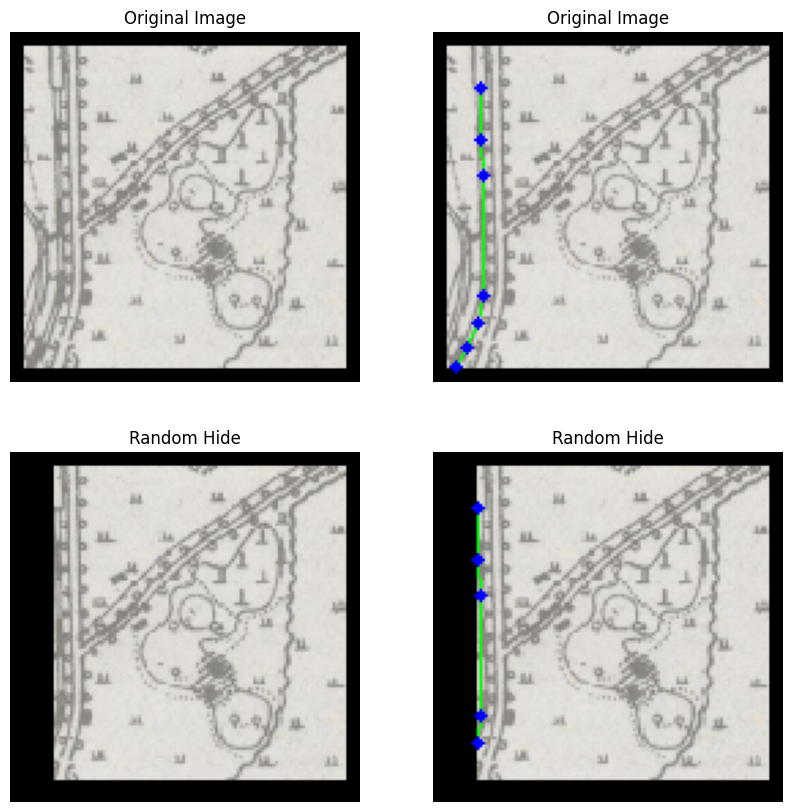

In [465]:
draw_compare(image, ori_image, hide_LineData.image, hide_image, "Random Hide", bw=False)

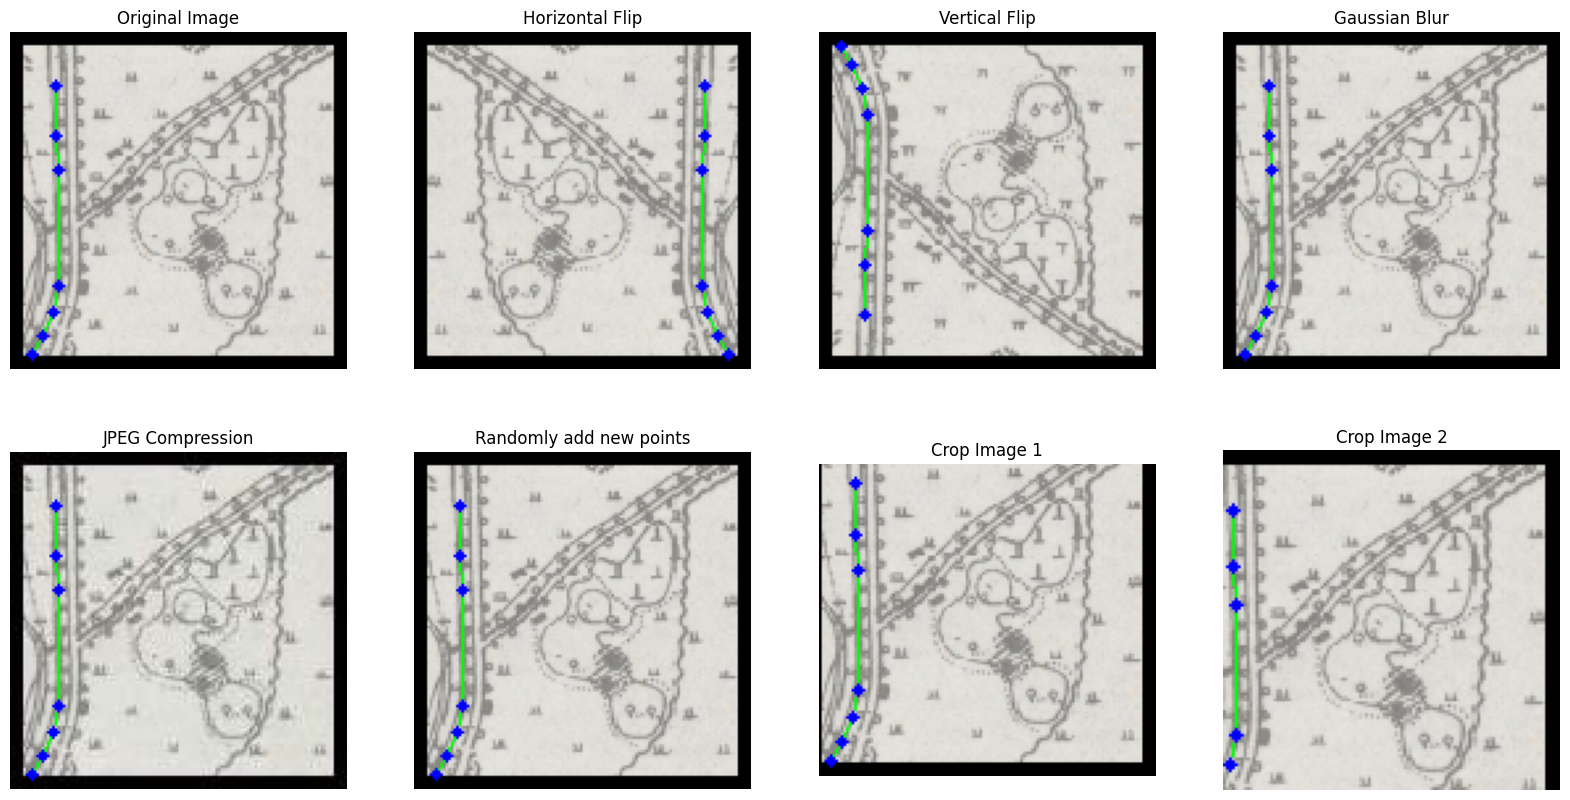

In [466]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.axis('off') 
plt.imshow(ori_image)
plt.title("Original Image")
plt.subplot(2, 4, 2)
plt.axis('off') 
plt.title("Horizontal Flip")
plt.imshow(hori_image)
plt.subplot(2, 4, 3)
plt.axis('off') 
plt.title("Vertical Flip")
plt.imshow(vert_image)
plt.subplot(2, 4, 4)
plt.axis('off') 
plt.title("Gaussian Blur")
plt.imshow(gblur_image)
plt.subplot(2, 4, 5)
plt.axis('off') 
plt.title("JPEG Compression")
plt.imshow(jpeg_image)
plt.subplot(2, 4, 6)
plt.axis('off') 
plt.title("Randomly add new points")
plt.imshow(addpoint_image)
plt.subplot(2, 4, 7)
plt.axis('off') 
plt.title("Crop Image 1")
plt.imshow(crop_image1)
plt.subplot(2, 4, 8)
plt.axis('off') 
plt.title("Crop Image 2")
plt.imshow(crop_image2)